In [1]:
import os
import numpy as np

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# !rm -rf pytorch-lib
# !git clone https://github.com/woolly-of-cv/pytorch-lib.git

In [4]:
import sys
sys.path.append(os.path.join(os.getcwd(), "pytorch-lib/"))
# print(sys.path)

In [5]:
from woollylib import main
from woollylib.utils.utils import get_device
# from woollylib.bp.vanila.backpropagation import train, test
from woollylib.bp.autocast.backpropagation import train, test

In [6]:
batch_size = 512
ricap_beta = 0.4
class_map = {
    'PLANE': 0,
    'CAR': 1,
    'BIRD': 2,
    'CAT': 3,
    'DEER': 4,
    'DOG': 5,
    'FROG': 6,
    'HORSE': 7,
    'SHIP': 8,
    'TRUCK': 9
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [7]:
use_cuda, device = get_device()

In [8]:
from woollylib.main import train_test_load
# from woollylib.preloading.dataset import train_test_load

train_loader, test_loader = train_test_load(batch_size, use_cuda, ricap_beta)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
epochs = 24
lr = 0.045
max_lr = 0.45
steps_per_epoch = len(train_loader)
dropout = False
drop_ratio = 0.1
use_l1 = False
lambda_l1 = 1e-7
min_momentum = 0.9
momentum = 0.9
weight_decay = 0.0005
weight_decay = weight_decay # / batch_size

norm='bn'
ctype='vanila'
train_function=train
test_function=test

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("Dropout Ratio:", drop_ratio)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Use L1:", use_l1)
print("L1 Lambda:", lambda_l1)
print("RICAP Beta", ricap_beta)

Using Device: cuda
Epochs: 24
Lr: 0.045
Max Lr: 0.45
Batch Size: 512
Dropout: False
Dropout Ratio: 0.1
Momentum: 0.9
Weight Decay: 0.0005
Use L1: False
L1 Lambda: 1e-07
RICAP Beta 0.4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

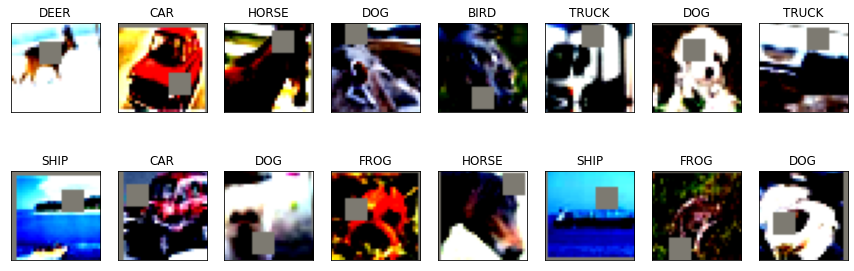

In [10]:
from woollylib.main import get_samples_visualize
get_samples_visualize(show_dataset_analyze, train_loader, class_map)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.56E-01


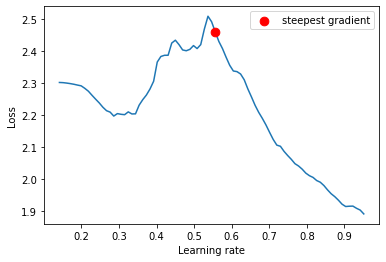

In [11]:
from woollylib.models.custom.custom_resnet import CustomResNet
from woollylib.main import get_optimizer
from torch_lr_finder import LRFinder

# Create model instance based on parameter which one to use
model = CustomResNet(norm=norm, ctype=ctype).to(device)
optimizer, criteria = get_optimizer(model, lr, momentum, weight_decay, device)


# lr_finder = LRFinder(model, optimizer, criteria, device=device)
# lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

lr_finder = LRFinder(model, optimizer, criteria, device=device)
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

In [12]:
from woollylib.models.custom.custom_resnet import CustomResNet
from woollylib.main import get_optimizer, get_scheduler
from woollylib.utils.utils import initialize_weights, print_summary, print_modal_summary
from torch.cuda.amp import GradScaler

scaler = GradScaler()
ctrain = train_function(use_l1=use_l1, lambda_l1=lambda_l1)

# Create model instance based on parameter which one to use
model = CustomResNet(norm=norm, ctype=ctype).to(device)
optimizer, criteria = get_optimizer(model, lr, momentum, weight_decay, device)

custom_scheduler= get_scheduler(epochs, lr, max_lr, min_momentum, momentum, optimizer, steps_per_epoch)


from woollylib.training import Training
# Create instance of trainer with all params
trainer = Training(
    model,
    optimizer,
    criteria,
    custom_scheduler,
    ctrain,
    test_function,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout,
    scaler
)

if show_summary:
    print_summary(model, input_size=(3, 32, 32))
#     print_modal_summary(trainer.model)

# Run trainer
trainer.run()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          WyConv2d-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
          WyConv2d-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
         WyConv2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,456
         WyConv2d-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

In [13]:
# Visualize network performance

from woollylib.visualize import plot_network_performance
from woollylib.utils import get_incorrrect_predictions
from woollylib.visualize import plot_incorrect_predictions

from woollylib.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from woollylib.visualize import plot_confusion_matrix


#     trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

ModuleNotFoundError: No module named 'woollylib.visualize'

In [ ]:
from woollylib.utils.gradcam.compute import compute_gradcam

count = 10
for i, (image, label, pred, output) in enumerate(incorrect):
    compute_gradcam(model, class_map, image, label, pred, device=device)
    if i == count-1:
        break